In [1]:
import torch
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F


import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Model(nn.Module):
    def __init__(self, input_channel, label_num, model_name, input_size = 224, batchnorm = False):
        super(Model,self).__init__()
        

        self.conv1 = make_conv(model_name[1],3,batchnorm) 
        self.conv2 = make_conv(model_name[2],64,batchnorm)
        self.conv3 = make_conv(model_name[3],128,batchnorm)
        self.conv4 = make_conv(model_name[4],256,batchnorm)
        self.conv5 = make_conv(model_name[5],512,batchnorm)

        self.fc_layer = make_fc(input_size,label_num)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

vgg11 = {1:[64],2:[128],3:[256,256],4:[512,512],5:[512,512]}
vgg13 = {1:[64,64],2:[128,128],3:[256,256],4:[512,512],5:[512,512]}
vgg16 = {1:[64,64],2:[128,128],3:[256,256,256],4:[512,512,512],5:[512,512,512]}
vgg19 = {1:[64,64],2:[128,128],3:[256,256,256,256],4:[512,512,512,512],5:[512,512,512,512]}

def make_conv(list_conv,input_channels,batchnorm=False):
    layers = []
    in_planes = input_channels
    for value in list_conv:
        if batchnorm == False: 
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1,stride =1 ))
            layers.append(nn.ReLU())
            in_planes = value
        else : 
            layers.append(nn.Conv2d(in_planes, value, kernel_size=3, padding=1,stride =1 ))
            #layers.append(nn.BatchNorm2d())# 논문에는 없지만 개선을 위해 추가 
            layers.append(nn.ReLU())
            in_planes = value
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

def make_fc(input_size,label_num):
    layers = []

    if input_size == 224: 
        layers.append(nn.Linear(512*7*7, 4096))
    elif input_size == 32: 
        layers.append(nn.Linear(512*1*1, 4096))
    else :
        pass 
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(4096,4096))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(4096,1000))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.5))
    layers.append(nn.Linear(1000, label_num))

    return nn.Sequential(*layers)


In [3]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = torch.load('../VGG/weight_2022-09-29-02vgg16_cifar10_5.pt')
net = net.to(device)
net.eval()

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequ

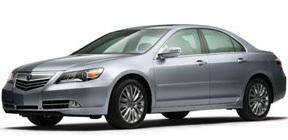

In [4]:
import PIL
img_dir = '../Car_data/car_ims'
img_name = '000096.jpg'
img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img


In [5]:
pil_img_size = np.array(pil_img).shape
print(pil_img_size)

def normalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.sub(mean).div(std)

(140, 288, 3)


In [6]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return self.do(tensor)
    
    def do(self, tensor):
        return normalize(tensor, self.mean, self.std)
    
    def undo(self, tensor):
        return denormalize(tensor, self.mean, self.std)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [7]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.interpolate(torch_img, size=(224, 224), mode='bilinear', align_corners=False) # (1, 3, 224, 224)
normed_torch_img = normalizer(torch_img) # (1, 3, 224, 224)

print(normed_torch_img)


C:\Users\mjy22\AppData\Local\Temp\ipykernel_11836\3398826168.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:178.)
  torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()


tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

In [16]:
import datetime
import shutil
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H')

saved_loc = os.path.join('./', current_time)
if os.path.exists(saved_loc):
    shutil.rmtree(saved_loc)
os.mkdir(saved_loc)

print("결과 저장 위치: ", saved_loc)

결과 저장 위치:  ./2022-09-29-23


In [17]:
from torch.autograd import Function


class GuidedBackpropReLU(Function):
    @staticmethod
    def forward(self, input_img):
        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask = (input_img > 0).type_as(input_img)
        
        # torch.addcmul(input, tensor1, tensor2) => output = input + tensor1 x tensor 2
        # input image와 동일한 사이즈의 torch.zeros를 만든 뒤, input image와 positive_mask를 곱해서 output 생성
        output = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), input_img, positive_mask)
        
        # backward에서 사용될 forward의 input이나 output을 저장
        self.save_for_backward(input_img, output)
        return output

    @staticmethod
    def backward(self, grad_output):
        
        # forward에서 저장된 saved tensor를 불러오기
        input_img, output = self.saved_tensors
        grad_input = None

        # input image 기준으로 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_1 = (input_img > 0).type_as(grad_output)
        
        # 모델의 결과가 양수인 부분만 1로 만드는 positive_mask 생성
        positive_mask_2 = (grad_output > 0).type_as(grad_output)
        
        # 먼저 모델의 결과와 positive_mask_1과 곱해주고,
        # 다음으로는 positive_mask_2와 곱해줘서 
        # 모델의 결과가 양수이면서 input image가 양수인 부분만 남도록 만들어줌
        grad_input = torch.addcmul(torch.zeros(input_img.size()).type_as(input_img),
                                   torch.addcmul(torch.zeros(input_img.size()).type_as(input_img), grad_output,
                                                 positive_mask_1), positive_mask_2)
        return grad_input

In [18]:
class GuidedBackpropReLUModel:
    def __init__(self, model, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        def recursive_relu_apply(module_top):
            for idx, module in module_top._modules.items():
                recursive_relu_apply(module)
                if module.__class__.__name__ == 'ReLU':
                    module_top._modules[idx] = GuidedBackpropReLU.apply

        # replace ReLU with GuidedBackpropReLU
        recursive_relu_apply(self.model)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        input_img = input_img.requires_grad_(True)

        output = self.forward(input_img)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()

        one_hot = torch.sum(one_hot * output)
        # 모델이 예측한 결과값을 기준으로 backward 진행
        one_hot.backward(retain_graph=True)

        # input image의 gradient를 저장
        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))
        return output

In [19]:
def deprocess_image(img):
    """ see https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py#L65 """
    img = img - np.mean(img)
    img = img / (np.std(img) + 1e-5)
    img = img * 0.1
    img = img + 0.5
    img = np.clip(img, 0, 1)
    return np.uint8(img * 255)

In [20]:
input_img = torch.randn(1,3,224,224).to(device)
out = net(input_img)
print(out)

tensor([[-3.3484, -4.1967,  0.4781,  1.7515,  3.5684, -2.1709, -1.9212, -1.1570,
         -2.5330,  0.1221]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [21]:
# final conv layer name 
finalconv_name = 'conv1'

# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data)
    

# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])
    

net._modules.get(finalconv_name).register_forward_hook(hook_feature)
net._modules.get(finalconv_name).register_backward_hook(backward_hook)

In [22]:
# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy()) # [1000, 512]
print(weight_softmax.shape)

# Prediction
print(normed_torch_img.shape)
logit = net(normed_torch_img)
print(logit)

(10, 1000)
torch.Size([1, 3, 224, 224])
tensor([[ -2.5308, 103.0327, -41.2608, -33.9450, -59.1538, -37.3991, -22.7850,
         -64.2246,   2.3438,  41.3301]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


c:\Users\mjy22\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [23]:
# ============================= #
# ==== Grad-CAM main lines ==== #
# ============================= #


# Tabby Cat: 281, pug-dog: 254
score = logit[:, 2].squeeze() # 예측값 y^c
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

print(score)

tensor(-41.2608, device='cuda:0', grad_fn=<SqueezeBackward0>)


In [24]:
activations = feature_blobs[0].to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
b, k, u, v = gradients.size()

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

In [25]:
grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(224, 224), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

In [26]:
import cv2

# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy

# Grad-CAM heatmap save
cv2.imwrite(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg"), grad_heatmap)

grad_heatmap = np.float32(grad_heatmap) / 255
print(grad_heatmap.shape)

(224, 224, 3)


In [27]:
print(normed_torch_img.shape)
print(normed_torch_img)

torch.Size([1, 3, 224, 224])
tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.

In [28]:
img = normed_torch_img.squeeze().cpu()
print(img.shape)
img = img.numpy().transpose((1, 2, 0))
print(img.shape)

#

torch.Size([3, 224, 224])
(224, 224, 3)


In [29]:
# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy

# Grad-CAM heatmap save
cv2.imwrite(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg"), grad_heatmap)

grad_heatmap = np.float32(grad_heatmap) / 255

grad_result = grad_heatmap + img
grad_result = grad_result / np.max(grad_result)
grad_result = np.uint8(255 * grad_result)

# Grad-CAM Result save
cv2.imwrite(os.path.join(saved_loc, "Grad_Result.jpg"), grad_result)

True

In [30]:
net.eval()

Model(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequ

In [31]:
# ============================= #
# ==Guided-Backprop main lines= #
# ============================= #

# gb_model => ReLU function in resnet50 change to GuidedBackpropReLU.
gb_model = GuidedBackpropReLUModel(model=net, use_cuda=True)
gb_num = gb_model(torch_img, target_category = 2)
gb = deprocess_image(gb_num) # (224, 224, 3), numpy

# Guided Backprop save
cv2.imwrite(os.path.join(saved_loc, "Guided_Backprop.jpg"), gb)

True

In [32]:
# Guided-Backpropagation * Grad-CAM => Guided Grad-CAM 
# See Fig. 2 in paper.
# grad_cam_map : (1, 1, 224, 224) , torch.Tensor
grayscale_cam = grad_cam_map.squeeze(0).cpu().numpy() # (1, 224, 224), numpy
grayscale_cam = grayscale_cam[0, :] # (224, 224)
cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam]) # (224, 224, 3)

cam_gb = deprocess_image(cam_mask * gb_num)

# Guided Grad-CAM save
cv2.imwrite(os.path.join(saved_loc, "Guided_Grad_CAM.jpg"), cam_gb)

True

In [34]:
Original_image = cv2.cvtColor(cv2.imread(os.path.join(img_dir, img_name)), cv2.COLOR_BGR2RGB)
G_heatmap = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Grad_CAM_heatmap.jpg")), cv2.COLOR_BGR2RGB)
G_result = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Grad_Result.jpg")), cv2.COLOR_BGR2RGB)
G_Back = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Guided_Backprop.jpg")), cv2.COLOR_BGR2RGB)
G_CAM = cv2.cvtColor(cv2.imread(os.path.join(saved_loc, "Guided_Grad_CAM.jpg")), cv2.COLOR_BGR2RGB)


Total = cv2.hconcat([Original_image, G_heatmap, G_result, G_Back, G_CAM])

plt.rcParams["figure.figsize"] = (20, 4)
plt.imshow(Total)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig(os.path.join(saved_loc, "Final_result.jpg"))
plt.show()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_operations.cpp:67: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'cv::hconcat'


In [ ]:
import os 
import glob 
import cv2

Grad_Heatmap = cv2.cvtColor(cv2.imread(os.path.join('./2022-10-04-17-52',"Grad_CAM_heatmap.jpg")),cv2.COLOR_BGR2RGB)

ModuleNotFoundError: No module named 'cv2'

In [ ]:
img = glob.glob('./alexnet_2022-10-20-11-01/Grad_CAM_heatmap.jpg')